# Tracking highly motile cells using flow field estimation and Ultrack

Tracking highly motile cells can be challenge. Here wee show how you can estimate the flow of cells to assist with tracking motile cells.

For this purpose we analyise the Tribolium Castaneum embryo 3D cartographic projection from the [cell tracking challenge](http://celltrackingchallenge.net/3d-datasets), the cells in this dataset show a clear migration pattern, their movement are further amplified on the vertical edges of the image due to projection artifacts.

First, we download the data from their website.

In [1]:
!wget -nc http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DL-TRIC.zip
!unzip -n Fluo-N3DL-TRIC.zip

File ‘Fluo-N3DL-TRIC.zip’ already there; not retrieving.

Archive:  Fluo-N3DL-TRIC.zip


We import the required packages. You can install them using the conda environment file in this folder.

In [2]:
from pathlib import Path

import napari
import numpy as np
import pandas as pd
import dask.array as da
import scipy.ndimage as ndi
from napari.utils.notebook_display import nbscreenshot
from rich.pretty import pprint
from tifffile import imread

from traccuracy import run_metrics
from traccuracy.loaders import load_ctc_data
from traccuracy.matchers import CTCMatched
from traccuracy.metrics import CTCMetrics, DivisionMetrics

from ultrack import MainConfig, add_flow, segment, link, solve, to_tracks_layer, tracks_to_zarr, to_ctc
from ultrack.imgproc import array_apply, create_zarr, robust_invert, detect_foreground
from ultrack.imgproc.flow import timelapse_flow, advenct_from_quasi_random, trajectories_to_tracks
from ultrack.utils.cuda import on_gpu
from ultrack.analysis.tracks import displacement

We set the download dataset path, open a napari viewer and open the images using napari's default reader.

We restrict our selves to the last 50 frames have a shorter timelapse and that's where the cells are more motile.

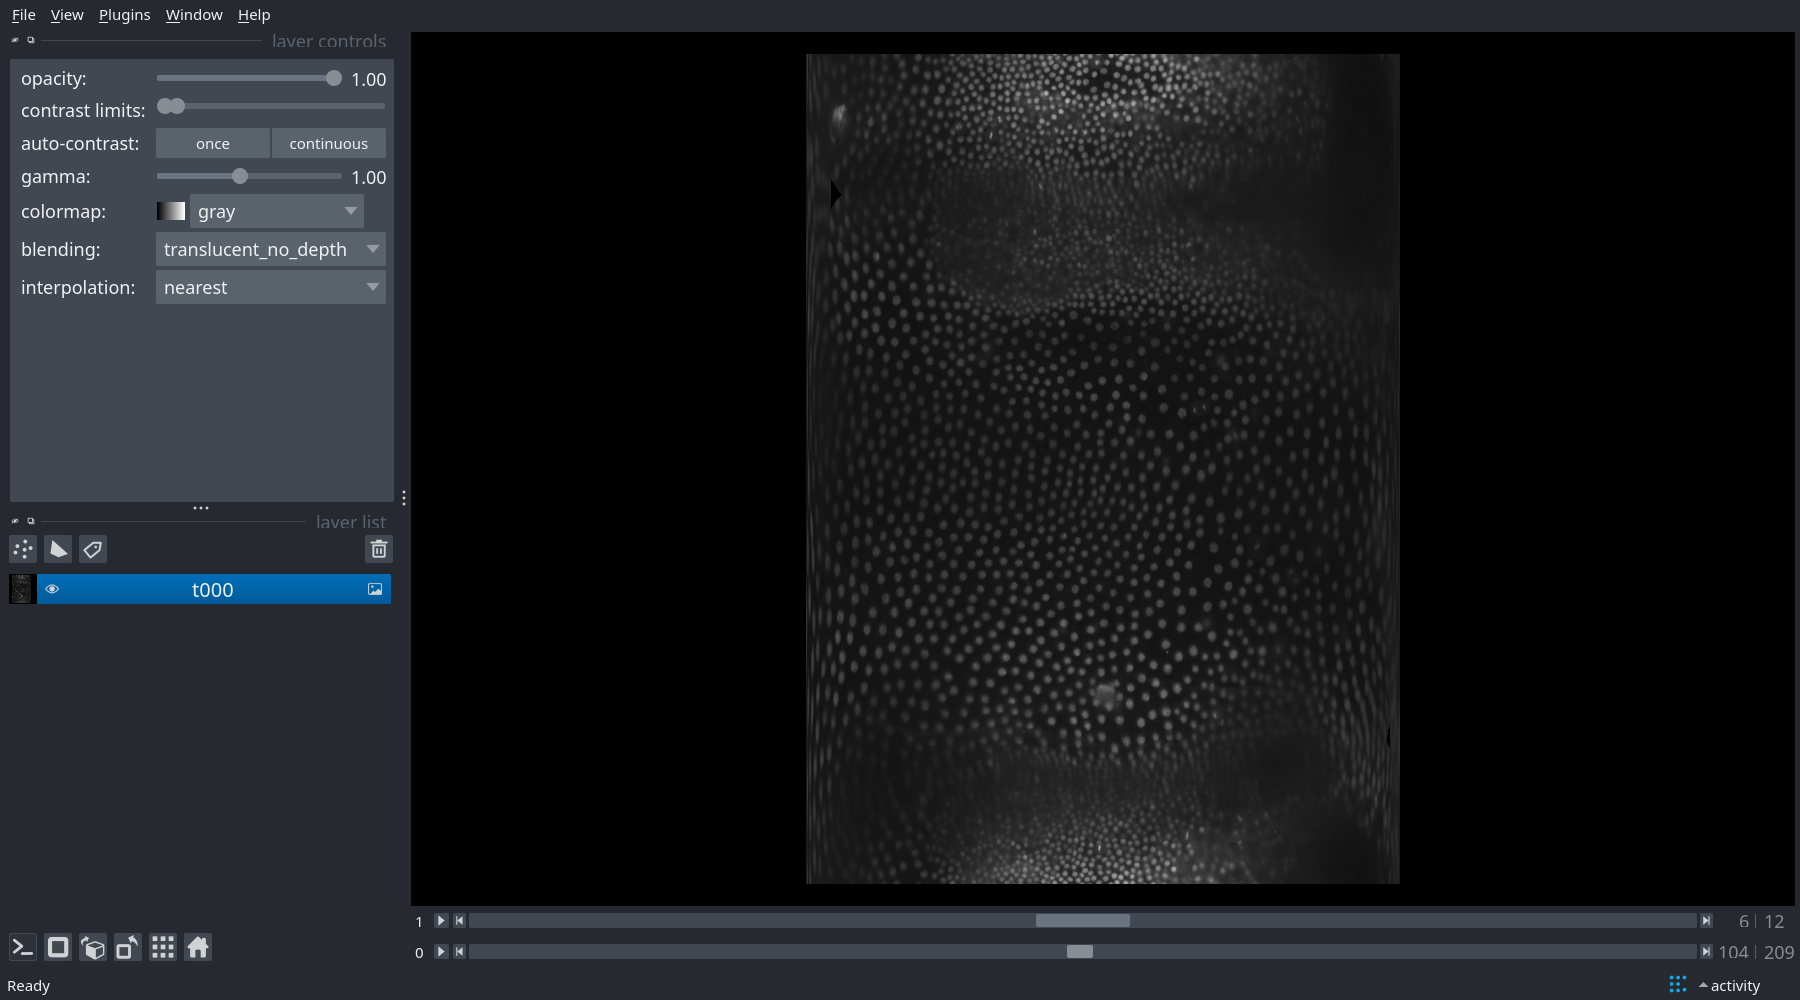

In [3]:
dataset_path = Path("Fluo-N3DL-TRIC/02")
# loading the last 50 frame where interesting happens
# im_files = sorted(dataset_path.glob("*.tif"))[-50:]
im_files = sorted(dataset_path.glob("*.tif"))  # uncomment to run the whole dataset

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)

im_layer = viewer.open(im_files, stack=True)
image = viewer.layers[0].data

nbscreenshot(viewer)

We detect which pixels contains cells and which are background using the `array_apply` function to apply the `detect_foreground` to each individual time point while saving it to the `detection.zarr` path.

Applying detect_foreground ...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [05:47<00:00,  1.66s/it]


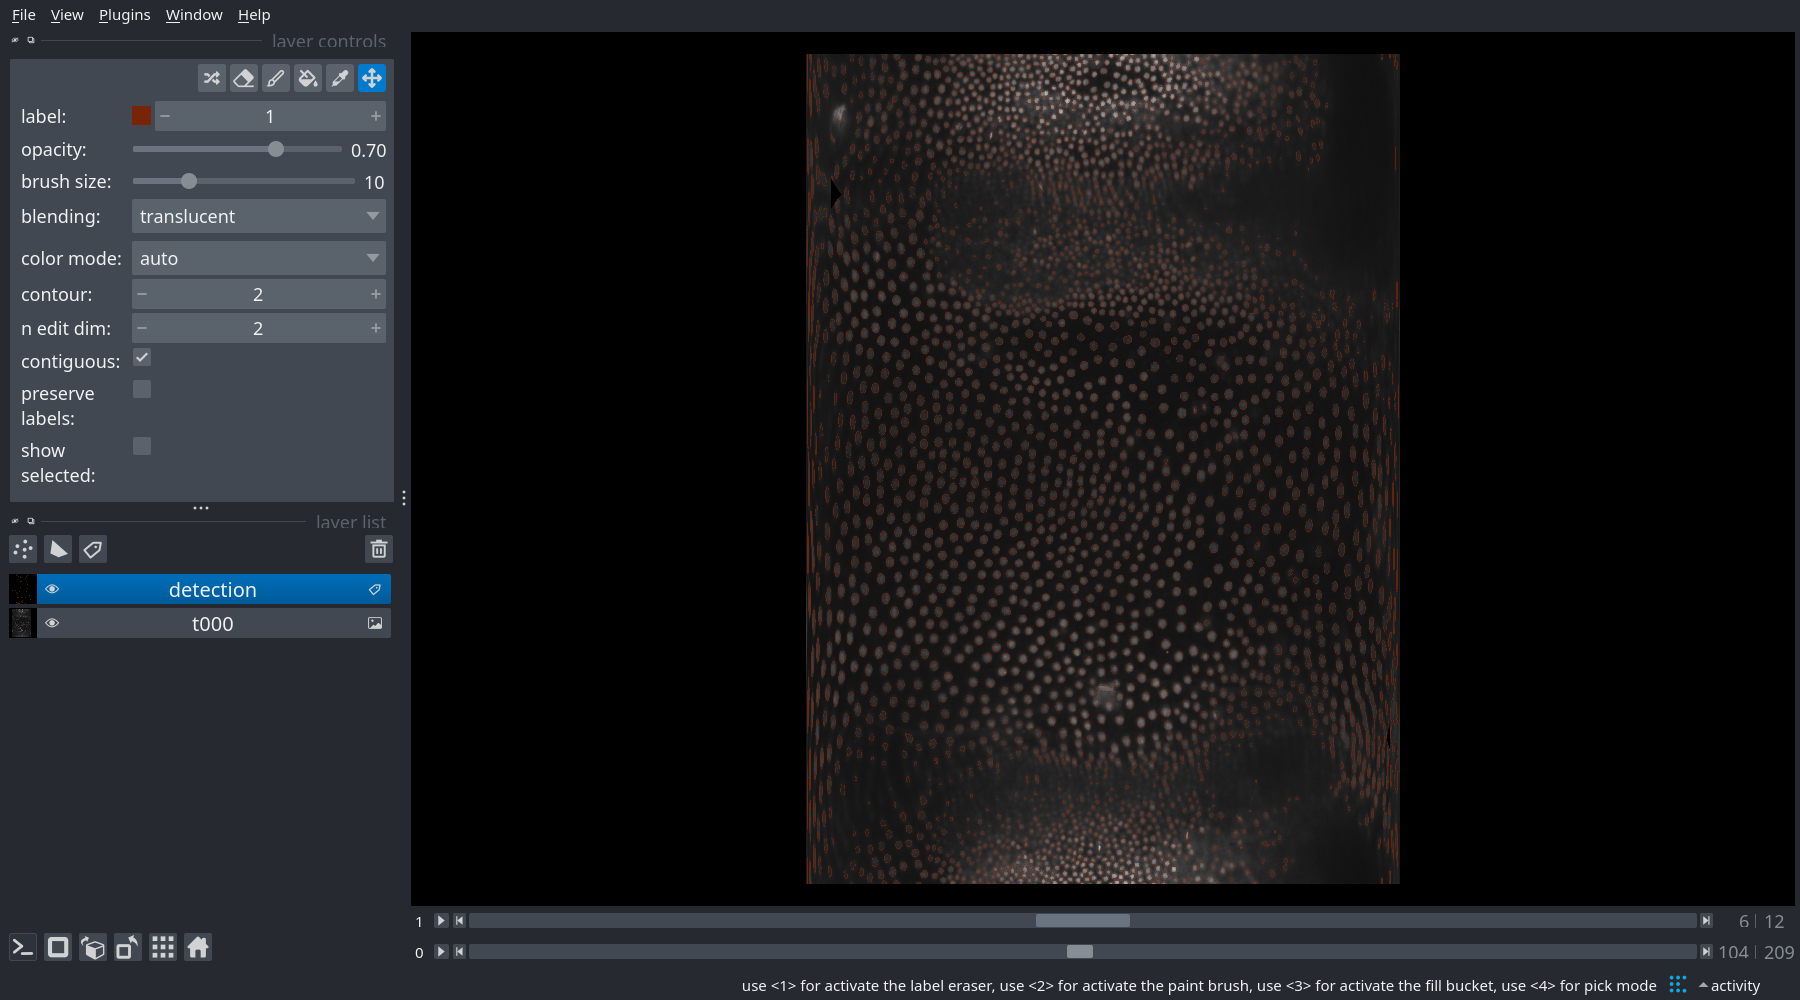

In [4]:
detection = create_zarr(image.shape, bool, "detection.zarr", overwrite=True)
array_apply(
    image,
    out_array=detection,
    func=on_gpu(detect_foreground),
)

viewer.add_labels(detection, visible=True).contour = 2

nbscreenshot(viewer)

Ultrack requires an estimate of the cell boundaries, we approximate this by inverting the image using the `robust_invert` function and saving it to `boundaries.zarr`.

In [5]:
boundaries = create_zarr(image.shape, np.float16, "boundaries.zarr", overwrite=True)
array_apply(
    image,
    out_array=boundaries,
    func=on_gpu(robust_invert),
    sigma=3.0,
)

viewer.add_image(boundaries, visible=False)

Applying robust_invert ...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [04:29<00:00,  1.28s/it]


<Image layer 'boundaries' at 0x7f446e723df0>

Using the original images we compute the movement flow. We use a lower number of `n_scales` because we the `z` dimension is very short, using the default `n_scales=3` results in a zero-length dimension.

In [6]:
!rm -r flow.zarr # removing previous flow
flow = timelapse_flow(image, store_or_path="flow.zarr", n_scales=2, lr=1e-2, num_iterations=2_000)
viewer.add_image(
    flow,
    contrast_limits=(-0.001, 0.001),
    colormap="turbo",
    visible=False,
    scale=(4,) * 3,
    channel_axis=1,
    name="flow field",
)

Computing flow:   0%|                                                                                                                                          | 0/209 [00:00<?, ?it/s]/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/torch/nn/functional.py:4332: UserWarning: Since version 1.3.0, affine_grid behavior has changed for unit-size grids when align_corners=True. This is not an intended use case of affine_grid. See the documentation of affine_grid for details.
  warnings.warn(
Computing flow: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [20:44<00:00,  5.96s/it]


[<Image layer 'flow field' at 0x7f4429aa0c10>,
 <Image layer 'flow field [1]' at 0x7f43f31a15d0>,
 <Image layer 'flow field [2]' at 0x7f4466ed26b0>]

To evaluate the flow you can advenct through the flow field using the centroids of the connected components of the first frame as the initial conditions.

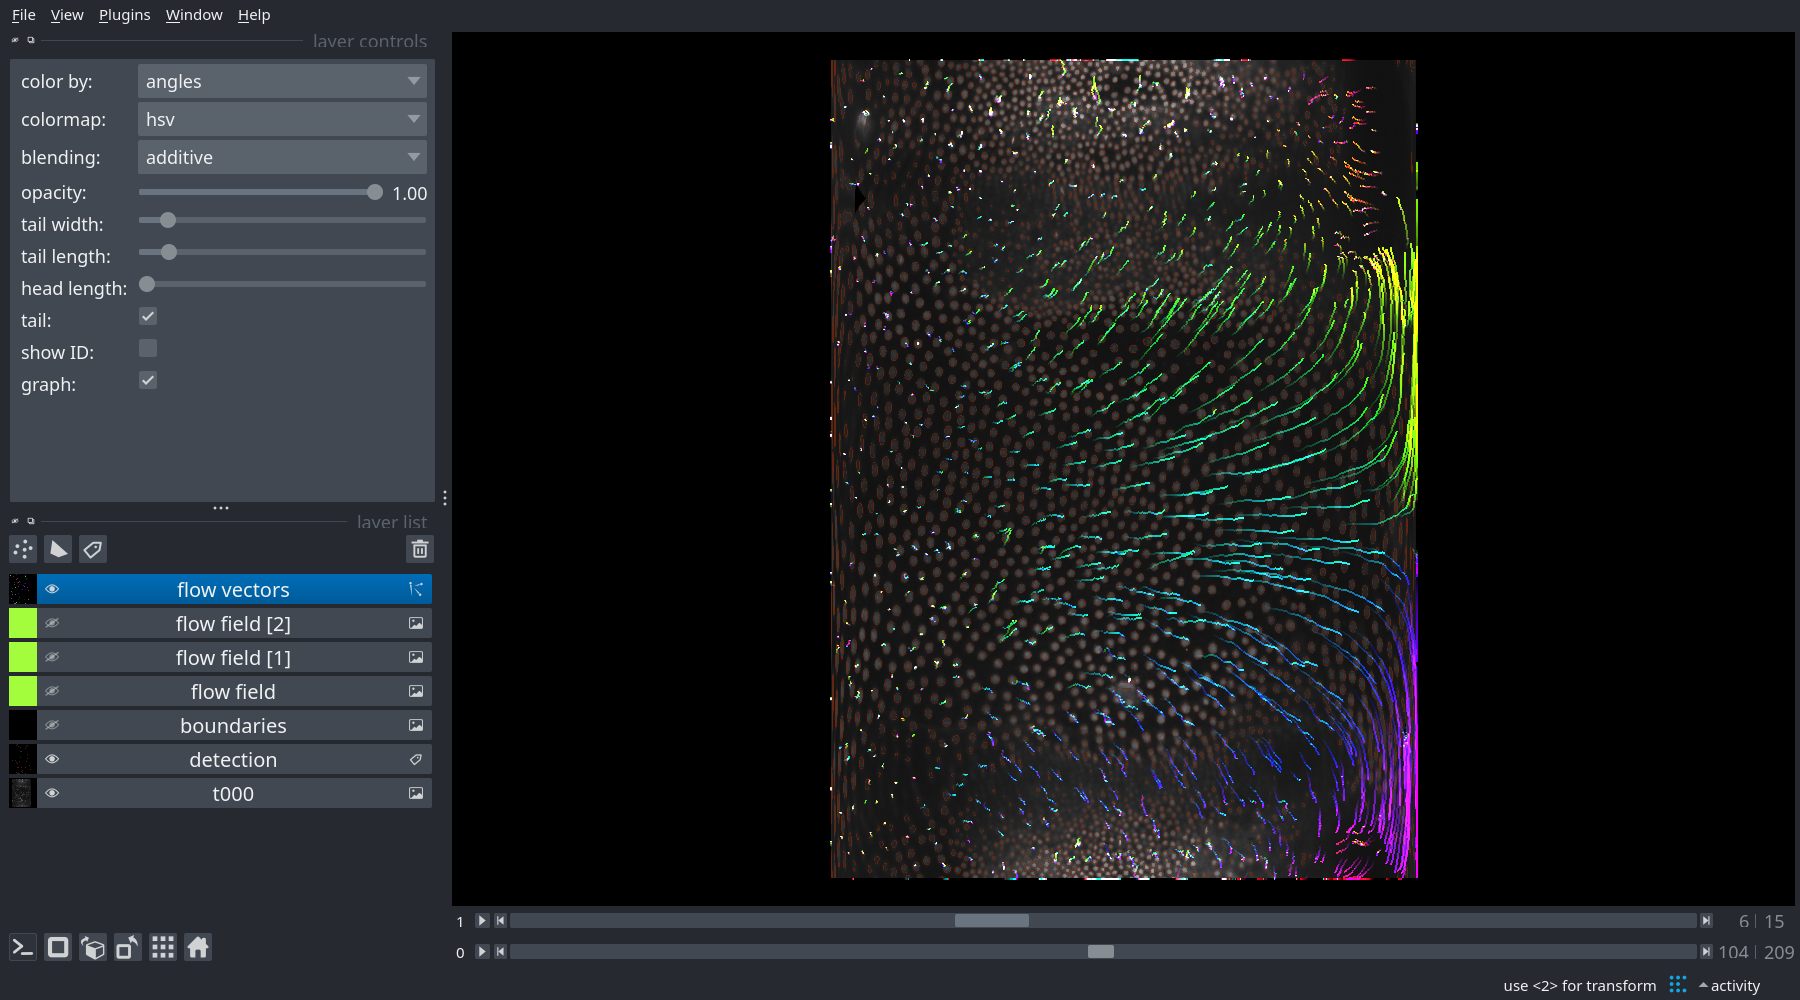

In [7]:
trajectory = advenct_from_quasi_random(flow, detection.shape[-3:], n_samples=1000)
flow_tracklets = pd.DataFrame(
    trajectories_to_tracks(trajectory),
    columns=["track_id", "t", "z", "y", "x"],
)
flow_tracklets[["z", "y", "x"]] += 0.5  # napari was crashing otherwise, might be an openGL issue
flow_tracklets[["dz", "dy", "dx"]] = displacement(flow_tracklets)
flow_tracklets["angles"] = np.arctan2(flow_tracklets["dy"], flow_tracklets["dx"])

flow_tracklets.to_csv("flow_tracklets.csv", index=False)

viewer.add_tracks(
    flow_tracklets[["track_id", "t", "z", "y", "x"]],
    name="flow vectors",
    visible=True,
    tail_length=25,
    features=flow_tracklets[["angles", "dy", "dx"]],
    colormap="hsv",
).color_by="angles"

nbscreenshot(viewer)

Now that we have our `detection`, `boundaries` and `flow`, and have checked that they look ok, we will start the tracking step.
Ultrack's tracking **with flow** relies on 4 steps and their respective python functions:
- `segment`: Computes the segmentation hypothesis for tracking;
- `add_flow`: Adds the flow to each segmentation hypothesis, must be called before `link`;
- `link`: Links and assign edge weights to the segmentation hypothesis taking into consideration the previously added flow;
- `solve`: Solves the tracking problem by selecting the strongly connected segmentation hypothesis.

All of these steps use our configuration object, `MainConfig`, which we'll set up below. It's documentation can be found [here](https://github.com/royerlab/ultrack/blob/main/ultrack/config/README.md).

The parameters were chosen manually by inspection.

NOTE: If you're running out of memory you should decrease the `n_workers` parameters. If you want to speed up the processing and have spare memory you can increase it.

In [8]:
cfg = MainConfig()

cfg.data_config.n_workers = 8

cfg.segmentation_config.n_workers = 8
cfg.segmentation_config.min_area = 500
cfg.segmentation_config.max_area = 15_000

cfg.linking_config.n_workers = 12
cfg.linking_config.max_neighbors = 5
cfg.linking_config.max_distance = 25.0

cfg.tracking_config.window_size = 50
cfg.tracking_config.overlap_size = 5
cfg.tracking_config.appear_weight = -0.01
cfg.tracking_config.disappear_weight = -0.001
cfg.tracking_config.division_weight = 0

pprint(cfg)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=8),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=500,
│   │   max_area=75000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f44d208ff40>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=12,
│   │   max_neighbors=5,
│   │   max_distance=25.0,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.01,
│   │   disappear_weight=-0.001,
│   │   division_weight=0,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=50,
│   │   overlap_size=5,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

Next, compute the set of candidate segmentation hypothesis from the `detection` and `boundaries` maps.

In [13]:
segment(detection, boundaries, cfg, overwrite=True)

Adding nodes to database: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [21:22<00:00,  6.11s/it]


In [14]:
link(cfg, overwrite=True)
solve(cfg)

Linking nodes.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:28<00:00,  7.43it/s]


Academic license - for non-commercial use only - expires 2024-08-06
Using GRB solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1296454 rows, 2282002 columns and 4900259 nonzeros
Model fingerprint: 0xedcdf053
Variable types: 0 continuous, 2282002 integer (2282002 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-20, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 235230 rows and 342243 columns (presolve time = 5s) ...
Presolve removed 235668 rows and 343315 columns (presolve time = 10s) ...
Presolve removed 477025 rows and 685991 columns (presolve time = 29s) ...
Presolve removed 477025 rows and 685991 columns
Presolve time: 28.96s
Presolved: 819429 rows, 1596011 columns, 3514377 nonzeros
F

In [15]:
gt_path = dataset_path.parent / "02_GT"
reference_frame = imread(gt_path / "TRA/man_track000.tif")

no_flow_res_path = Path("02_NO_FLOW_RES/TRA")
to_ctc(no_flow_res_path, cfg, first_frame=reference_frame, overwrite=True)

Exporting segmentation masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:12<00:00, 17.08it/s]


In [16]:
add_flow(cfg, flow)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:08<00:00, 25.52it/s]


In [17]:
link(cfg, overwrite=True)
solve(cfg)

flow_res_path = Path("02_FLOW_RES/TRA")
to_ctc(flow_res_path, cfg, first_frame=reference_frame, overwrite=True)

Linking nodes.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:28<00:00,  7.40it/s]


Academic license - for non-commercial use only - expires 2024-08-06
Using GRB solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1296454 rows, 2282002 columns and 4900259 nonzeros
Model fingerprint: 0xd9c64a3f
Variable types: 0 continuous, 2282002 integer (2282002 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-20, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 235230 rows and 342243 columns (presolve time = 5s) ...
Presolve removed 477025 rows and 685991 columns (presolve time = 27s) ...
Presolve removed 477025 rows and 685991 columns
Presolve time: 27.10s
Presolved: 819429 rows, 1596011 columns, 3514377 nonzeros
Found heuristic solution: objective 36126.376986
Variable types: 0 continuo

Exporting segmentation masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:12<00:00, 17.25it/s]


In [18]:
gt_data = load_ctc_data(gt_path / "TRA")

no_flow_results = run_metrics(
    gt_data=gt_data, 
    pred_data=load_ctc_data(no_flow_res_path),
    matcher=CTCMatched,
    metrics=[CTCMetrics],
)
pprint(no_flow_results)

Matching frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [01:20<00:00,  2.61it/s]


Matched 32376 out of 34253 ground truth nodes.
Matched 31406 out of 34501 predicted nodes.


Evaluating FN edges: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34055/34055 [00:03<00:00, 10736.28it/s]


{
│   'CTCMetrics': {
│   │   'AOGM': 32677.5,
│   │   'fp_nodes': 3095,
│   │   'fn_nodes': 1877,
│   │   'ns_nodes': 918,
│   │   'fp_edges': 26,
│   │   'fn_edges': 4057,
│   │   'ws_edges': 111,
│   │   'TRA': 0.9169805328844993,
│   │   'DET': 0.9227658891192012
│   }
}

In [19]:
to_ctc(flow_res_path, cfg, first_frame=reference_frame, overwrite=True)
flow_results = run_metrics(
    gt_data=gt_data, 
    pred_data=load_ctc_data(flow_res_path),
    matcher=CTCMatched, 
    metrics=[CTCMetrics], # , DivisionMetrics],
)
pprint(flow_results)

Matching frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [01:14<00:00,  2.81it/s]


Matched 32413 out of 34253 ground truth nodes.
Matched 31389 out of 34259 predicted nodes.


Evaluating FN edges: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34055/34055 [00:03<00:00, 10669.89it/s]


{
│   'CTCMetrics': {
│   │   'AOGM': 32403.5,
│   │   'fp_nodes': 2870,
│   │   'fn_nodes': 1840,
│   │   'ns_nodes': 963,
│   │   'fp_edges': 25,
│   │   'fn_edges': 4125,
│   │   'ws_edges': 106,
│   │   'TRA': 0.9176766489885357,
│   │   'DET': 0.9238460864741774
│   }
}

We export the resulting tracks into the napari tracks format and a zarr with the instance segmentation masks.

Exporting segmentation masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:34<00:00,  6.16it/s]


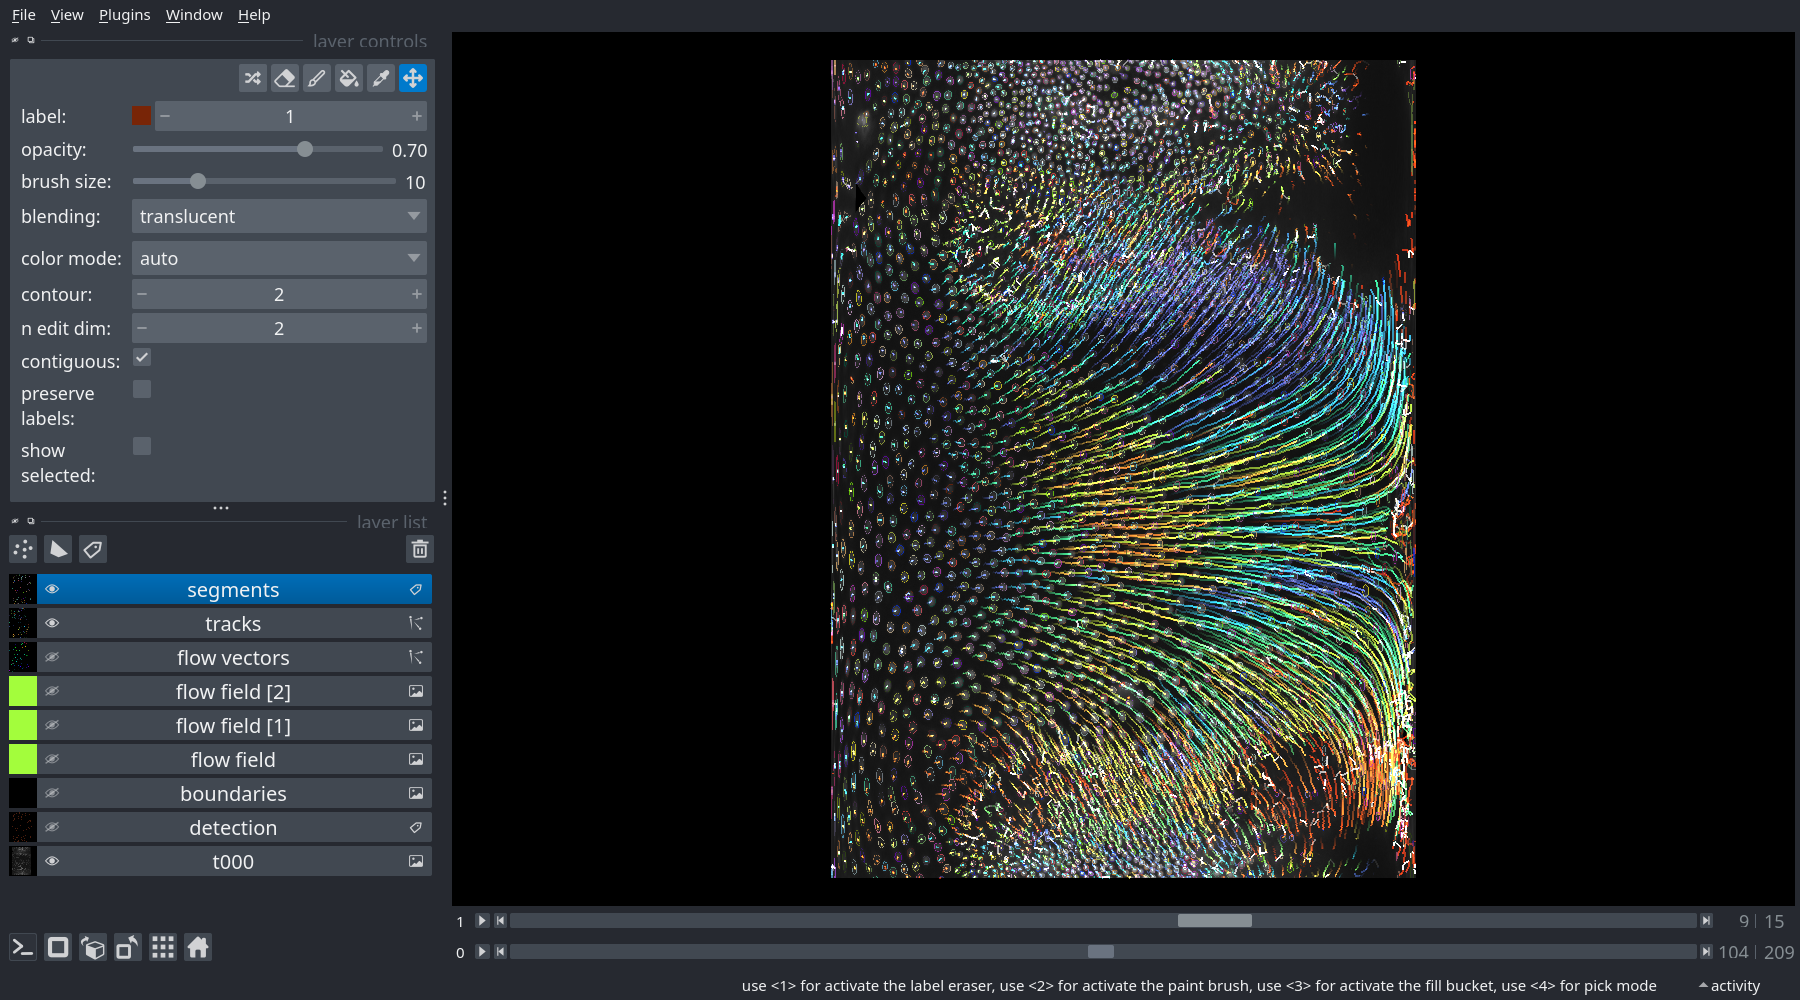

In [20]:
!rm -r segments.zarr  # removing previous segmentation

tracks_df, graph = to_tracks_layer(cfg)
tracks_df.to_csv("tracks.csv", index=False)

segments = tracks_to_zarr(
    cfg,
    tracks_df,
    store_or_path="segments.zarr",
)

viewer.layers["flow vectors"].visible = False
viewer.layers["detection"].visible = False
viewer.add_tracks(
    tracks_df[["track_id", "t", "z", "y", "x"]],
    name="tracks",
    graph=graph,
    visible=True,
)

viewer.add_labels(da.from_zarr(segments), name="segments").contour = 2

nbscreenshot(viewer)